<h1 align=center><font size=5>Customer segmentation
  
In this practice, we analyze the content of the [E-commerce database](https://www.kaggle.com/carrie1/ecommerce-data) that contains purchases made by about 4000 customers over a period of one year (from 2010/12/01 to 2011/12/09).
  
We then try to segment the customers into several categories, and try to classify new customers into those categories.

# 1) Data preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1) Download dataset

**Task:** Download the data set, and read the description [here](https://archive.ics.uci.edu/ml/datasets/Online%20Retail) to understand the features.


In [3]:
!pip install kaggle


In [4]:
import os
os.environ['KAGGLE_KEY']= '' # Enter your own kaggle key
os.environ['KAGGLE_USERNAME']="kipkuruimutai"

In [5]:
!kaggle datasets list -s E-Commerce

ref                                                    title                                              size  lastUpdated          downloadCount  
-----------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
carrie1/ecommerce-data                                 E-Commerce Data                                     7MB  2017-08-17 02:44:30          50826  
nicapotato/womens-ecommerce-clothing-reviews           Women's E-Commerce Clothing Reviews                 3MB  2018-02-03 19:59:19          30723  
olistbr/brazilian-ecommerce                            Brazilian E-Commerce Public Dataset by Olist       43MB  2018-11-29 12:22:57          54510  
jmmvutu/summer-products-and-sales-in-ecommerce-wish    Sales of summer clothes in E-commerce Wish        376KB  2020-08-23 15:16:46          11251  
benroshan/ecommerce-data                               E-Commerce Data                                    

In [6]:
! kaggle datasets download carrie1/ecommerce-data 
from zipfile import ZipFile 
file_name = "/content/ecommerce-data.zip"
with ZipFile(file_name, 'r') as zip:                      # 'r' -> READ mode 
    zip.printdir() # print all the contents 
    zip.extractall()

del zip

!head -5 /content/data.csv


 69% 5.00M/7.20M [00:00<00:00, 38.6MB/s]
100% 7.20M/7.20M [00:00<00:00, 45.1MB/s]
File Name                                             Modified             Size
data.csv                                       2019-09-20 22:35:12     45580638
InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom


##1.2)  Read data + timestamp

**Task:** Read the data into a pandas dataframe `df`, investigate shape and head. Investigate the types of the features, and use `pd.to_datetime` to transform the timestamps features(InvoiceDate) to the correct format, also change the data type of CustomerID with the option dtype={'CustomerID': str} in dataframe


<br>
The format of data may cause you some problem, if so, have a look here:<br>
https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas-with-python


In [7]:
import pandas as pd
data = pd.read_csv("/content/data.csv", encoding='unicode_escape', dtype={"CustomerID":str}) #encoding=latin
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])


In [8]:
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object

##1.3) Missing values

**Task:** Find the percentage of missing values for each feature. Create a new dataframe `df_dropna` by removing observations without CustomerID. 

In [9]:
# observations containing NaN
data.loc[data.isnull().sum(axis=1) > 0].head(10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1448,536544,21791,VINTAGE HEADS AND TAILS CARD GAME,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1449,536544,21801,CHRISTMAS TREE DECORATION WITH BELL,10,2010-12-01 14:32:00,0.43,NaN,United Kingdom
1450,536544,21802,CHRISTMAS TREE HEART DECORATION,9,2010-12-01 14:32:00,0.43,NaN,United Kingdom
1451,536544,21803,CHRISTMAS TREE STAR DECORATION,11,2010-12-01 14:32:00,0.43,NaN,United Kingdom


In [10]:
# missing percentages
data.isnull().sum(axis=0) / data.shape[0]


InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64

In [11]:
# if we drop all entries with unknown customer ID, missing values in Description also disappear
data_dropna = data.dropna(axis = 0, subset = ['CustomerID', 'Description'])

# missing percentages
data_dropna.isnull().sum(axis=0) / data_dropna.shape[0]


InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

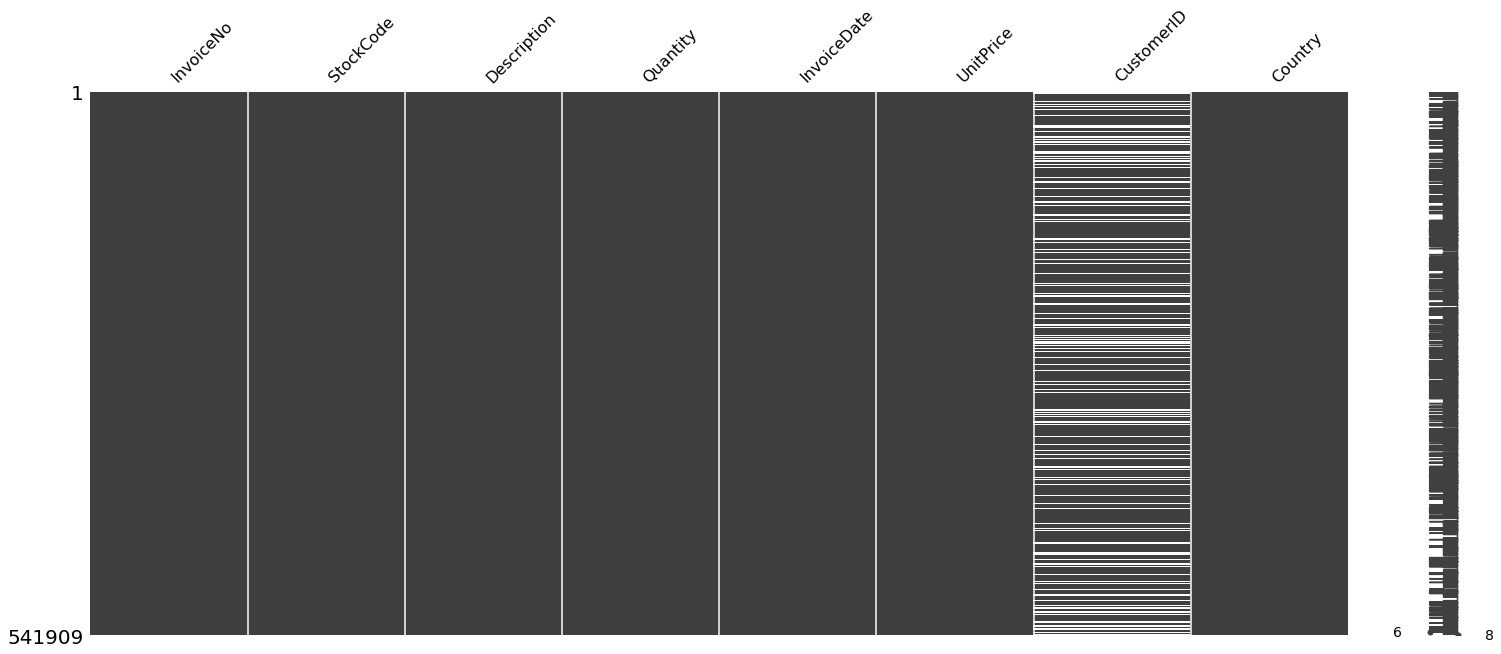

In [12]:
import missingno as msno

msno.matrix(data)


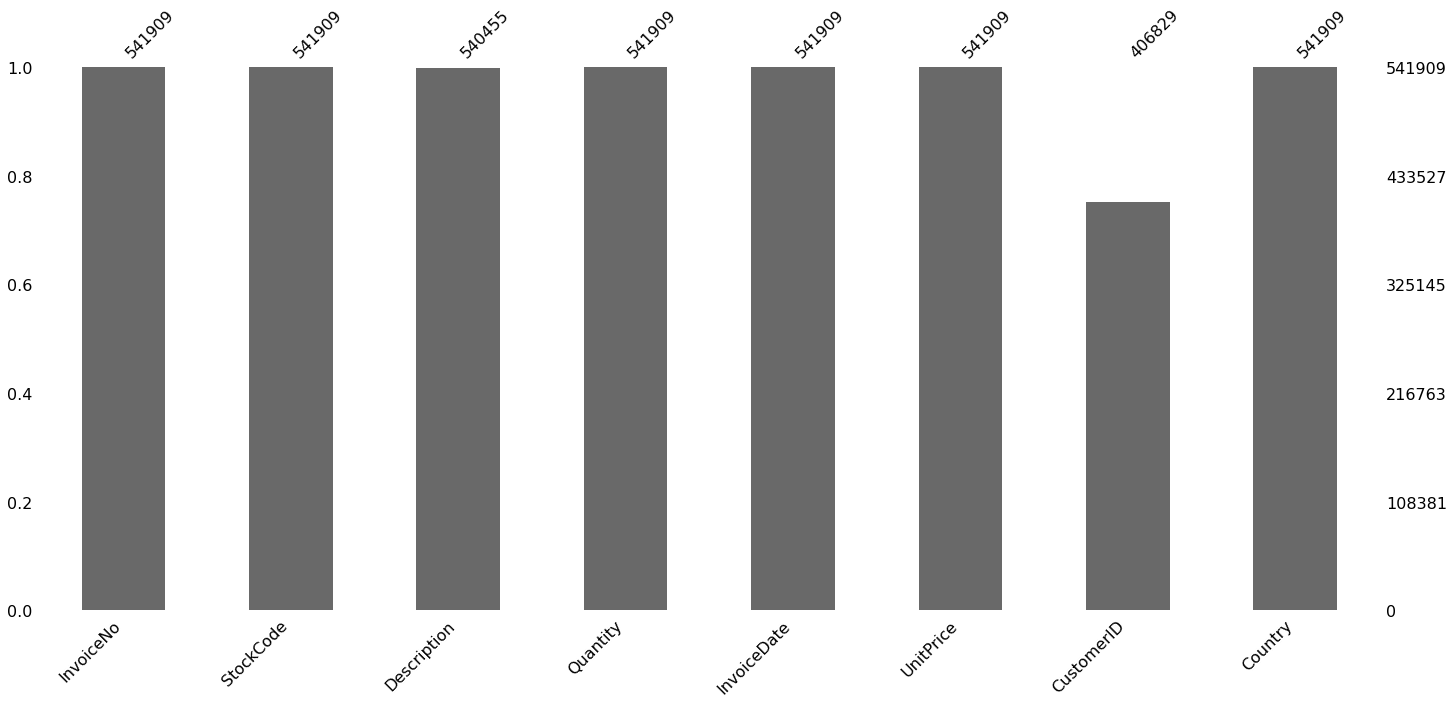

In [13]:
msno.bar(data)


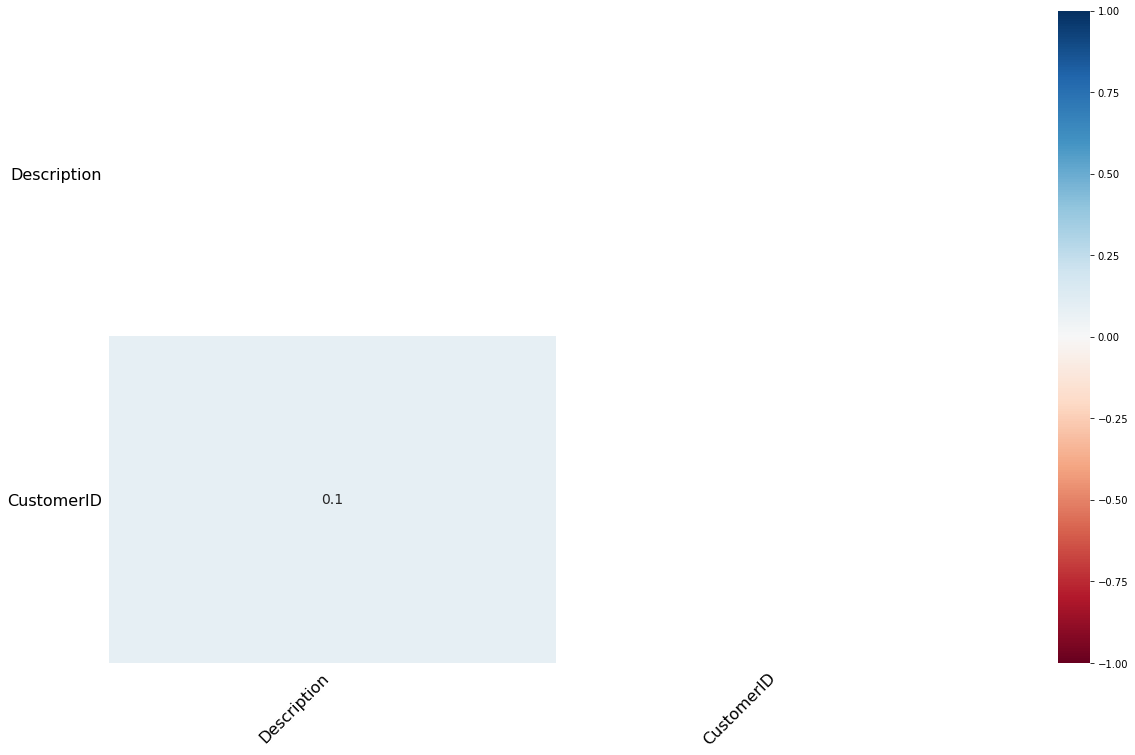

In [14]:
msno.heatmap(data)


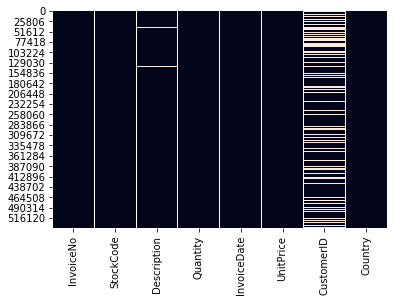

In [15]:
import seaborn as sns
sns.heatmap(data.isna(), cbar=False)


## 1.4) Duplicates

**Task:** Is there any duplicate in the data i.e. 2 identical observations? If it's the case, remove the duplicates (keep one for each distinct obervation of course) and save to `df_dropna`.
<br>
function:<br>
df.drop_duplicates

In [16]:
# some entries having duplicates
data_dropna.loc[data_dropna.duplicated(keep=False)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom


In [17]:
# check - should be zero if you done everything right wth df.duplicated().sum()


## 1.5) Save data
Save preprocessed data to the file `data_dropna.csv` and the original data to `data.csv`

In [18]:
relative_path ='/cont'#put you path on google drive here where you want to save
# data dataframe => relative_path+'/data.csv'
# data_dropna dataframe => relative_path+'/data_dropna.csv'
#save data and data_dropna

In [19]:
relative_path = '/content/drive/MyDrive/DATA'
data_dropna.to_csv(relative_path + 'data_dropna.csv') 
data.to_csv(relative_path + 'data.csv') 